In [1]:
# !apt-get install -y fonts-nanum
# !rm ~/.cache/matplotlib -rf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.font_manager as fm
import matplotlib as mpl

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글이 깨지지 않도록 하기 위해서 minus 표시를 설정합니다.
plt.rcParams['axes.unicode_minus'] = False

processed_seoul = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_seoul.csv')
processed_gyeonggi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_gyeonggi.csv')
processed_incheon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_incheon.csv')
processed_busan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_busan.csv')
processed_daegu = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_daegu.csv')
processed_gwangju = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_gwangju.csv')
processed_daejeon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_daejeon.csv')
processed_ulsan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_ulsan.csv')

# 도시별 df 딕셔너리
city_dfs = {
    '서울특별시': processed_seoul,
    '경기도': processed_gyeonggi,
    '인천광역시': processed_incheon,
    '부산광역시': processed_busan,
    '대구광역시': processed_daegu,
    '광주광역시': processed_gwangju,
    '대전광역시': processed_daejeon,
    '울산광역시': processed_ulsan
}

In [3]:
"""
데이터셋 칼럼 설명

0   '권역': 행정 구역 기준 권역 정보 (수도권/지방)
1   '시군구': 시/군/구 단위 행정 구역명
2   '번지': 도로명 주소의 번지 정보
3   '본번': 도로명 주소의 본번
4   '부번': 도로명 주소의 부번
5   '단지명': 아파트 단지 이름
6   '계약년월': 계약 발생 연월 (YYYYMM)
7   '계약년도': 계약 발생 연도 (YYYY)
8   '계약월': 계약 발생 월 (1~12)
9   '계약일': 계약 발생 일 (1~31)
10  'contract_season': 계약 발생 계절 (봄/여름/가을/겨울)
11  'area_bin': 전용면적 기준 면적 구간
    - 분류 기준:
        - ≤60 ㎡ : 소형
        - 61~85 ㎡ : 중소형
        - 86~135 ㎡ : 중대형
        - >135 ㎡ : 대형
12  '전용면적(㎡)': 아파트의 전용면적 (㎡)
13  '거래금액(만원)': 실제 거래 금액 (만원)
14  'price_per_m2': 평당 가격 (만원/㎡)
15  '층': 거래된 주택의 층수
16  '건축년도': 건물 준공 연도
17  'building_age': 건물 연식 (계약년도 - 건축년도)
18  'is_new_building': 신축 여부 (True: 5년 이하 신축)
19  'log_거래금액': 거래금액(만원)의 로그 변환 값
20  'log_price_per_m2': price_per_m2의 로그 변환 값
"""

processed_seoul.head()

,권역,시군구,번지,본번,부번,단지명,계약년월,계약년도,계약월,계약일,...,area_bin,전용면적(㎡),거래금액(만원),price_per_m2,층,건축년도,building_age,is_new_building,log_거래금액,log_price_per_m2
0,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201205,2012,5,17,...,중소형,73.50,38000.0,517.0,6,2000,12,False,10.545341,6.248043
1,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201507,2015,7,28,...,중소형,73.50,42000.0,571.4,3,2000,15,False,10.645425,6.348089
2,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201709,2017,9,23,...,중소형,71.72,64500.0,899.3,7,2000,17,False,11.074421,6.801617
3,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201707,2017,7,21,...,중소형,73.50,55400.0,753.7,2,2000,17,False,10.922335,6.624994
4,수도권,서울특별시 강남구 개포동,1164-13,1164,13,새롬(1164-13),201001,2010,1,5,...,소형,59.67,35000.0,586.6,3,2000,10,False,10.463103,6.374343


### **H3. 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가진다.**  
### **H4. 수도권보다는 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다.**
<br>

#### **검증 방법 및 분석 절차**

**1. 데이터 전처리 & 표본 추출 (Stratified Sampling)**

- **거래량 집계**
    - 2차 집계: 도시별 df에서 **`groupby(['시군구', '계약년도']).size()`**→ 해당 시군구·계약년도 단위의 총 거래량을 집계 (시장 유동성의 크기 반영용)
    - 3차 집계: 도시별 df에서 **`groupby(['시군구', '계약년도', 'is_new_building']).size()`**→ 신축 여부까지 구분한 세부 그룹의 거래량을 집계 (희소 셀 필터링용)
- **최소 표본 필터링 (3차 집계 기준)**
    - 세부 그룹(시군구×계약년도×신축 여부) 거래량이 임계값(**`MIN_CELL`**) 미만일 경우 제외
    - 이유: 지나치게 희소한 그룹은 통계적 신뢰도가 낮고, 표본에 포함될 경우 분석 왜곡 발생 가능
- **가중치 산출 (2차 집계 기준)**
    - 필터링 후 남은 데이터에서, 각 행이 속한 **`시군구-계약년도`** 그룹의 거래량을 가중치로 부여
    - 이유: 전체 시장에서 해당 시군구·연도의 거래량 비중을 반영하기 위함
- **계층화된 무작위 표본 추출 (차등 비율 적용)**
    - 층화 변수: **`권역`**, **`area_bin`**, **`is_new_building`**, **`계약년도`**
    - **표본 추출 비율**:
        - 수도권: 전체의 5-6% (약 13-15만 행)
        - 지방: 전체의 7-10% (약 10-14만 행)
        - 총 목표 표본: 20-30만 행
    - 지방 오버샘플링으로 H4 검증력 강화 및 도시별 세분화 분석 가능성 확보

**2. 변수 간 상관관계 및 정보량 분석 (표본 데이터 사용)**

- 로그 변환 변수(**`log_거래금액`**, **`log_price_per_m2`**)를 사용하며, 해석 시 거래금액 vs 평당가 차이를 구분
- 표본 데이터에 대해 **`전용면적(㎡)`**, **`계약년도`**, **`건축년도`**, **`building_age`** 등 주요 수치 변수와 로그 변환 변수 간 피어슨 상관계수 및 상호 정보량(MI) 계산

**3. 그룹별 분포 및 차이 분석 (표본 데이터 사용)**

- **`권역`**, **`area_bin`**, **`is_new_building`**, **`계약년도`** 등 주요 범주형 변수별 로그 변환 변수의 분포 시각화
    - **2×2 상호작용 그리드**: (수도권/지방) × (신축/구축) 4개 셀의 평균 **`log_price_per_m2`** + 95% 신뢰구간
    - **시간 트렌드 라인플롯**: 연도별 신축 프리미엄 추이를 수도권과 지방으로 구분하여 표시
    - **도시별 박스플롯**: 지방 5개 도시(부산, 대구, 광주, 대전, 울산) 각각의 신축/구축 가격 분포
- 거래량 가중치를 고려한 가중 평균 및 가중 ANOVA 검정 수행
- **전/후반기 비교**: 2010-2014년 vs 2015-2019년 기간별 신축 효과 변화 분석

**4. 다변량 회귀분석 (가중 최소 제곱, 표본 데이터 사용)**

- **기본 모델**:
    - 독립변수: **`전용면적(㎡)`**, **`building_age`**, **`C(area_bin)`**, **`C(is_new_building)`**, **`C(권역)`**, **`C(계약년도)`**
    - 종속변수: **`log_price_per_m2`**
    - 거래량 가중치를 부여한 WLS 회귀분석
- **상호작용 모델** (H3, H4 검증용):
    - 핵심 상호작용: **`C(권역):C(is_new_building)`**
    - 시간 상호작용: **`C(권역):C(계약년도)`** - 수도권/지방의 시간별 가격 변동 패턴 차이 포착
    - 계약년도를 다항식(polynomial) 또는 스플라인으로 처리하여 비선형 시간 트렌드 포착 가능
- **도시별 세분화 모델**:
    - 지방 데이터만 사용하여 **`C(도시):C(is_new_building)`** 상호작용 분석

**5. H3, H4 검증 지표 및 기준**

- **H3 검증 (지역별 중~큰 차별 효과)**:
    - 중간 효과: Cohen's d ≥ 0.5 또는 회귀계수 |β| ≥ 0.05 (로그스케일)
    - 큰 효과: Cohen's d ≥ 0.8 또는 회귀계수 |β| ≥ 0.10
    - 상호작용 항 **`C(권역):C(is_new_building)`**의 F-test p-value < 0.05
- **H4 검증 (지방 > 수도권 영향력)**:
    - 비교 지표: |β_지방×신축| / |β_수도권×신축| > 1.2 (지방이 20% 이상 큰 효과)
    - 두 계수의 95% 신뢰구간이 겹치지 않으면 강한 증거
    - 실제 가격 차이로 환산: exp(β) - 1 = 신축 프리미엄 %

In [4]:
# (시군구×계약년도×신축 여부) 그룹 임계값 설정
threshold = 30

combo_results = []

for city, city_df in city_dfs.items():
    total_rows = len(city_df)

    # (시군구, 계약년도, is_new_building) 조합별 행 수 계산
    combo_counts = city_df.groupby(['시군구', '계약년도', 'is_new_building']).size()

    # 임계값 미만인 조합
    mask = combo_counts < threshold
    low_sample_combos = combo_counts[mask]

    # 해당 조합의 행 수 합
    filtered_rows = low_sample_combos.sum()

    # 전체 대비 비율 계산
    percentage = (filtered_rows / total_rows * 100) if total_rows > 0 else 0

    combo_results.append({
        "도시": city,
        "임계값 미달 행수": filtered_rows,
        "전체 행수": total_rows,
        "비율(%)": round(percentage, 2)
    })

# 결과 DataFrame
combo_results_df = pd.DataFrame(combo_results)
display(combo_results_df)

# 임계값 = 30 일 때,
# 임계값 미달 행수가 전체 행의 1.10%~2.60% 정도로 매우 낮은 편으로 확인됨
# 따라서 거래 건수 기준 30건 미만인 그룹은 추가적인 분석에서 제외하기로 함

,도시,임계값 미달 행수,전체 행수,비율(%)
0,서울특별시,20385,784750,2.60
1,경기도,28657,1466358,1.95
2,인천광역시,3666,332003,1.10
3,부산광역시,8997,445732,2.02
4,대구광역시,6520,332090,1.96
5,광주광역시,3578,238439,1.50
6,대전광역시,3464,212397,1.63
7,울산광역시,4218,170410,2.48


In [5]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import mutual_info_regression

# def create_dummy_df(city_name: str, num_rows: int) -> pd.DataFrame:
#     """
#     분석을 위한 더미 데이터프레임을 생성합니다.
#     실제 데이터 로드를 시뮬레이션하기 위한 함수입니다.

#     Args:
#         city_name (str): 도시 이름 (예: '서울특별시', '부산광역시').
#         num_rows (int): 생성할 데이터 행의 수.

#     Returns:
#         pd.DataFrame: 생성된 더미 데이터프레임.
#     """
#     np.random.seed(42) # 재현성을 위해 시드 설정
#     is_capital_area = True if city_name in ['서울특별시', '경기도', '인천광역시'] else False

#     # 수도권과 지방 간 가격 차이 및 신축 프리미엄을 시뮬레이션하기 위한 기본 가격 설정
#     base_trade_price = np.random.normal(loc=150000, scale=30000, size=num_rows) # 평균 1억5천, 표준편차 3천
#     base_price_per_m2 = np.random.normal(loc=2000, scale=400, size=num_rows) # 평균 2000, 표준편도 400

#     # 수도권은 가격을 약간 높게 설정
#     if is_capital_area:
#         base_trade_price *= 1.3 # 수도권은 30% 높게
#         base_price_per_m2 *= 1.3

#     data = {
#         '권역': ['수도권' if is_capital_area else '지방'] * num_rows,
#         '시군구': [city_name] * num_rows,
#         '번지': [f'1-{i}' for i in range(num_rows)],
#         '본번': [1] * num_rows,
#         '부번': [i for i in range(num_rows)],
#         '단지명': [f'아파트{i}' for i in range(num_rows)],
#         '계약년월': np.random.randint(201001, 202001, num_rows), # 2010-2019년 범위로 설정
#         '계약년도': np.random.randint(2010, 2020, num_rows), # 2010-2019년 범위로 설정
#         '계약월': np.random.randint(1, 13, num_rows),
#         '계약일': np.random.randint(1, 31, num_rows),
#         'contract_season': np.random.choice(['봄', '여름', '가을', '겨울'], num_rows),
#         'area_bin': pd.Series(np.random.choice(['소형', '중소형', '중대형', '대형'], num_rows, p=[0.2, 0.4, 0.3, 0.1])).astype('category'),
#         '전용면적(㎡)': np.random.rand(num_rows) * 150 + 30, # 30~180
#         '거래금액(만원)': base_trade_price,
#         'price_per_m2': base_price_per_m2,
#         '층': np.random.randint(1, 30, num_rows),
#         '건축년도': np.random.randint(1970, 2019, num_rows), # 계약년도보다 이전
#         'is_new_building': np.random.choice([True, False], num_rows, p=[0.25, 0.75]), # 신축 비중을 높여 그룹이 잘 형성되도록
#     }
#     df = pd.DataFrame(data)
#     df['building_age'] = df['계약년도'] - df['건축년도']
#     df['log_거래금액'] = np.log(df['거래금액(만원)'].abs().replace(0, 1e-6))
#     df['log_price_per_m2'] = np.log(df['price_per_m2'].abs().replace(0, 1e-6))

#     # 더미 데이터에 시군구-계약년도-신축여부별 거래량 불균형 및 희소 그룹 시뮬레이션
#     if num_rows > 1000:
#         # 특정 시군구-년도-신축여부 조합의 데이터를 희소하게 만듦 (3차 집계 필터링용)
#         sparse_frac = 0.05 # 5%의 데이터를 희소하게 만듦
#         sparse_indices = df.sample(frac=sparse_frac, random_state=42).index
#         df.loc[sparse_indices, 'is_new_building'] = df.loc[sparse_indices, 'is_new_building'].apply(lambda x: not x) # 신축여부 토글

#         # 일부러 '가상의구'를 만들어 일부 그룹의 거래량을 50개 미만으로 만듦
#         # 이는 3차 집계 필터링에 걸리도록 함
#         df.loc[df.sample(frac=0.01, random_state=42).index, '시군구'] = '가상의구'

#     return df

# # 실제 데이터 로드를 시뮬레이션하기 위해 더미 데이터프레임 생성
# # 총 목표 표본: 20-30만 행 (필터링 및 샘플링 비율 고려하여 원본 데이터 크기 조정)
# # 수도권: 3개 도시, 지방: 5개 도시
# num_rows_metro = 400000 # 수도권 각 도시 당 40만 행
# num_rows_local = 300000 # 지방 각 도시 당 30만 행

# city_dfs = {
#     '서울특별시': create_dummy_df('서울특별시', num_rows_metro),
#     '경기도': create_dummy_df('경기도', num_rows_metro),
#     '인천광역시': create_dummy_df('인천광역시', num_rows_metro),
#     '부산광역시': create_dummy_df('부산광역시', num_rows_local),
#     '대구광역시': create_dummy_df('대구광역시', num_rows_local),
#     '광주광역시': create_dummy_df('광주광역시', num_rows_local),
#     '대전광역시': create_dummy_df('대전광역시', num_rows_local),
#     '울산광역시': create_dummy_df('울산광역시', num_rows_local)
# }

# 모든 도시 데이터 합치기
combined_df = pd.concat(city_dfs.values(), ignore_index=True)

# 'period_bin' 컬럼 생성 (전/후반기 비교용)
combined_df['period_bin'] = pd.cut(combined_df['계약년도'],
                                   bins=[2009, 2014, 2019],
                                   labels=['전반기', '후반기'], right=True, ordered=True)

# '도시' 컬럼 생성 (시군구의 첫 번째 띄어쓰기 기준으로 자름)
combined_df['도시'] = combined_df['시군구'].apply(lambda x: x.split(' ')[0])

In [6]:
# --- 1. 데이터 전처리 & 표본 추출 (Stratified Sampling) ---
print("--- 데이터 전처리 및 계층화 표본 추출 시작 ---", flush=True)

# 2차 집계: 시군구-계약년도 단위 총 거래량 (시장 유동성 크기 반영용 가중치)
transaction_counts_2nd = combined_df.groupby(['시군구', '계약년도']).size().reset_index(name='transaction_count_2nd')
combined_df = pd.merge(combined_df, transaction_counts_2nd, on=['시군구', '계약년도'], how='left')

# 3차 집계: 시군구-계약년도-신축여부 단위 세부 그룹 거래량 (희소 셀 필터링용)
transaction_counts_3rd = combined_df.groupby(['시군구', '계약년도', 'is_new_building']).size().reset_index(name='transaction_count_3rd')
combined_df = pd.merge(combined_df, transaction_counts_3rd, on=['시군구', '계약년도', 'is_new_building'], how='left')

# 최소 표본 필터링 (3차 집계 기준, 임계값 = 30)
MIN_CELL_THRESHOLD = 30
original_rows = len(combined_df)
filtered_df = combined_df[combined_df['transaction_count_3rd'] >= MIN_CELL_THRESHOLD].copy()
filtered_rows = len(filtered_df)
print(f"원본 데이터 총 행 수: {original_rows}", flush=True)
print(f"3차 집계 기준 (시군구×계약년도×신축여부) 거래량 {MIN_CELL_THRESHOLD}건 미만 필터링 후 총 행 수: {filtered_rows} ({filtered_rows/original_rows:.2%})", flush=True)

# 필터링 후 데이터 행 수 상세 표시 (도시별 / 권역별)
print("\n--- 필터링 후 데이터 행 수 상세 ---", flush=True)
print("도시별 행 수:", flush=True)
print(filtered_df.groupby('도시').size().sort_values(ascending=False), flush=True)
print("\n권역별 행 수:", flush=True)
print(filtered_df.groupby('권역').size(), flush=True)

# 가중치 산출 (2차 집계 기준, 정규화 없이 원래 거래량 사용)
if not filtered_df['transaction_count_2nd'].empty:
    # WLS를 위해 원래 거래량을 직접 가중치로 사용 (정규화 하지 않음)
    filtered_df['weights'] = filtered_df['transaction_count_2nd']
else:
    filtered_df['weights'] = 1.0

# 계층화된 무작위 표본 추출 (차등 비율 적용)
strat_cols = ['권역', 'area_bin', 'is_new_building', '계약년도']
sample_rate_metro = 0.05  # 수도권 5%
sample_rate_local = 0.07  # 지방 7%

# 표본 추출 전에 필요한 모든 컬럼이 있는지 확인
essential_cols = strat_cols + ['period_bin', '도시', 'weights', 'transaction_count_2nd', 'transaction_count_3rd']
missing_cols = [col for col in essential_cols if col not in filtered_df.columns]
if missing_cols:
    print(f"경고: 다음 변수들이 필터링된 데이터에 누락됨: {missing_cols}", flush=True)

# 층화 변수에 결측치가 있는 행 제거
sampled_df = filtered_df.dropna(subset=strat_cols).copy()

def differentiated_stratified_sample(group):
    """그룹의 권역에 따라 다른 샘플링 비율을 적용하여 표본을 추출합니다."""
    if group['권역'].iloc[0] == '수도권':
        sample_frac = sample_rate_metro
    else: # 지방
        sample_frac = sample_rate_local

    n_samples = max(1, int(len(group) * sample_frac))
    return group.sample(n=n_samples, random_state=42) if len(group) > 0 else group

if not sampled_df.empty:
    sampled_df = sampled_df.groupby(strat_cols, group_keys=False).apply(differentiated_stratified_sample).reset_index(drop=True)
else:
    print("경고: 필터링 후 데이터가 비어있어 표본 추출을 진행할 수 없습니다.", flush=True)

print(f"\n필터링 후 총 데이터 행 수: {len(filtered_df)}", flush=True)
print(f"계층화 표본 추출 후 최종 행 수: {len(sampled_df)}", flush=True)

# 샘플링 후 데이터 행 수 상세 표시 (도시별 / 권역별)
print("\n--- 계층화 표본 추출 후 데이터 행 수 상세 ---", flush=True)
print("도시별 행 수:", flush=True)
print(sampled_df.groupby('도시').size().sort_values(ascending=False), flush=True)
print("\n권역별 행 수:", flush=True)
print(sampled_df.groupby('권역').size(), flush=True)

print("--- 데이터 전처리 및 계층화 표본 추출 완료 ---", flush=True)

--- 데이터 전처리 및 계층화 표본 추출 시작 ---
원본 데이터 총 행 수: 3982179
3차 집계 기준 (시군구×계약년도×신축여부) 거래량 30건 미만 필터링 후 총 행 수: 3902694 (98.00%)

--- 필터링 후 데이터 행 수 상세 ---
도시별 행 수:
도시
경기도      1437701
서울특별시     764365
부산광역시     436735
인천광역시     328337
대구광역시     325570
광주광역시     234861
대전광역시     208933
울산광역시     166192
dtype: int64

권역별 행 수:
권역
수도권    2530403
지방     1372291
dtype: int64


/tmp/ipython-input-3671915031.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = sampled_df.groupby(strat_cols, group_keys=False).apply(differentiated_stratified_sample).reset_index(drop=True)



필터링 후 총 데이터 행 수: 3902694
계층화 표본 추출 후 최종 행 수: 222495

--- 계층화 표본 추출 후 데이터 행 수 상세 ---
도시별 행 수:
도시
경기도      72051
서울특별시    38234
부산광역시    30590
대구광역시    22792
광주광역시    16351
인천광역시    16191
대전광역시    14536
울산광역시    11750
dtype: int64

권역별 행 수:
권역
수도권    126476
지방      96019
dtype: int64
--- 데이터 전처리 및 계층화 표본 추출 완료 ---



--- 가설 H3, H4 검증 시작 (계층화 표본 데이터 기반) ---
----------------------------------------------------------

--- 표본 데이터: 수치형 변수 상관관계 및 정보량 분석 ---

  타겟: log_price_per_m2
  [피어슨 상관계수 (표본 데이터 기반)]
건축년도            0.226144
전용면적(㎡)         0.081424
building_age   -0.107792
Name: log_price_per_m2, dtype: float64
  [상호 정보량 (MI - 표본 데이터 기반)]
전용면적(㎡)         1.344883
건축년도            0.206541
building_age    0.102297
dtype: float64

--- 그룹별 분포 및 차이 분석 (H3, H4 관련) ---

  가중치를 고려한 Cohen's d 효과 크기 계산 (권역별 신축 vs 구축)
    수도권: Cohen's d = -0.3548 (작은 효과)
    지방: Cohen's d = -0.7426 (중간 효과)

  2x2 상호작용 그리드: 권역 × 신축 여부별 가중 평균 및 95% CI

    [가중 평균 및 신뢰구간]

    수도권:
      구축: 6.0229 [6.0196, 6.0261]
      신축: 6.1758 [6.1676, 6.1841]

    지방:
      구축: 5.5149 [5.5116, 5.5183]
      신축: 5.7890 [5.7830, 5.7950]


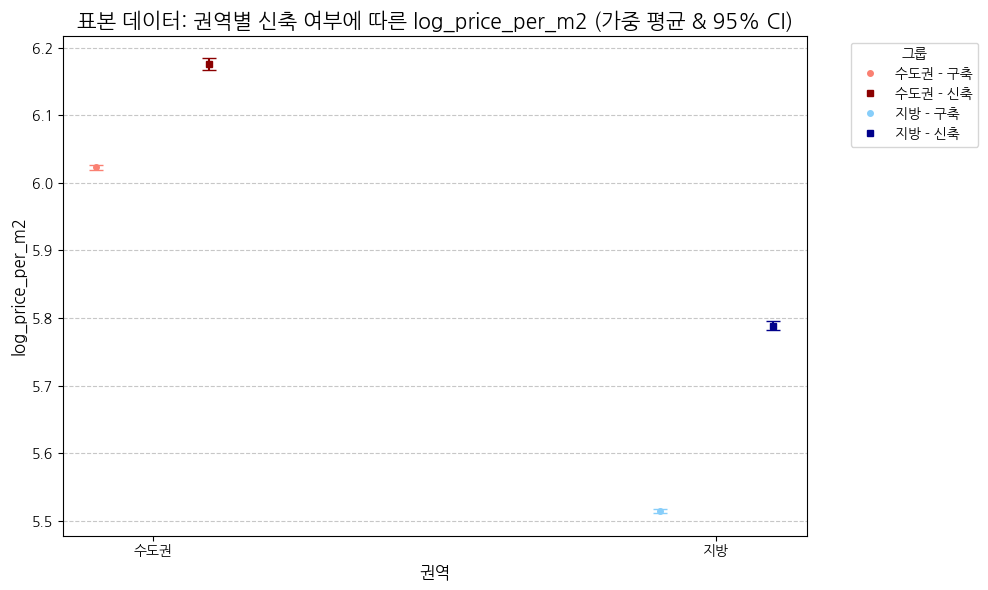


  연도별 신축 프리미엄 추이 분석


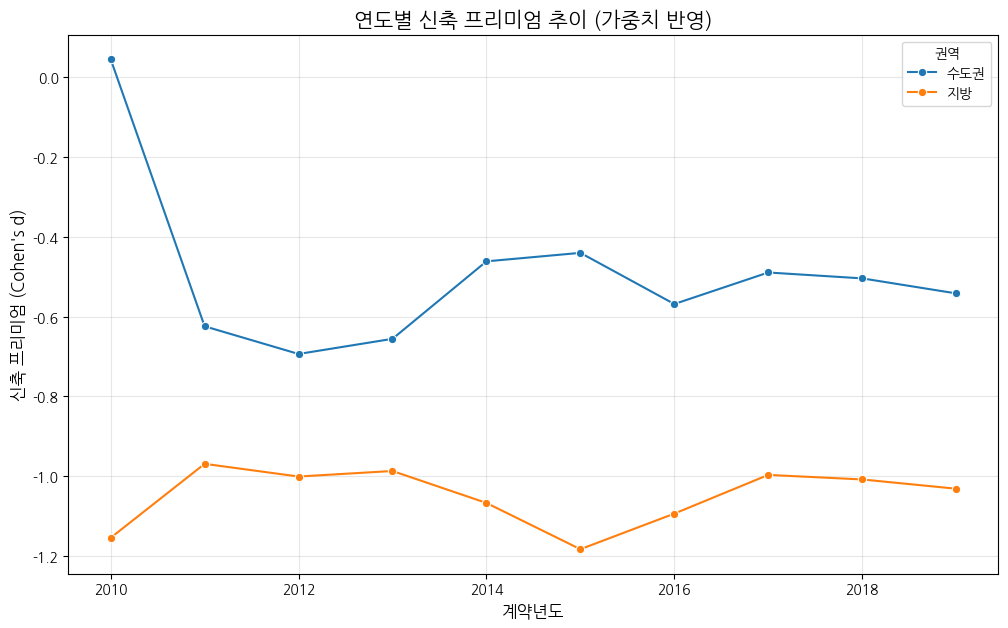


  지방 도시별 신축 여부에 따른 log_price_per_m2 분포


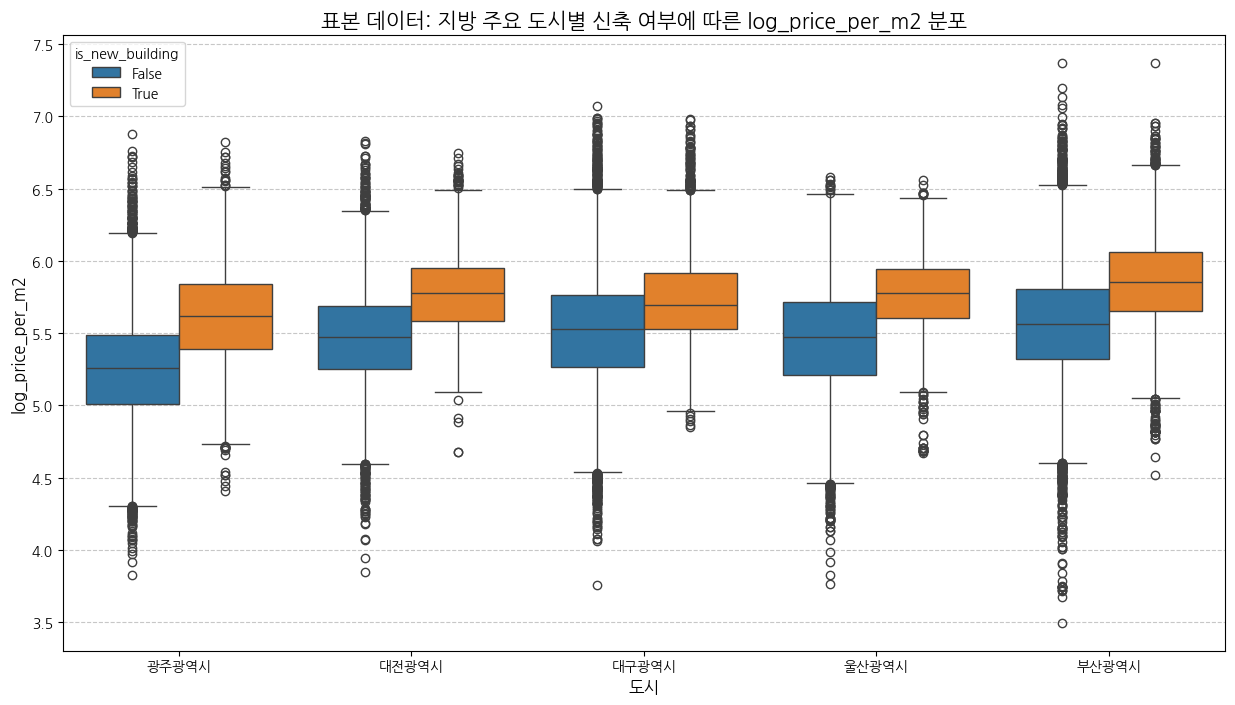


  기간별 (전반기 vs 후반기) 신축 효과 변화 분석 (WLS ANOVA)

    [ANOVA 결과]
                                        sum_sq        df             F  \
C(period_bin)                     6.039935e+06       1.0  38700.433343   
C(is_new_building)                8.599515e+05       1.0   5510.075170   
C(period_bin):C(is_new_building)  6.543438e+03       1.0     41.926589   
Residual                          3.472393e+07  222491.0           NaN   

                                        PR(>F)  
C(period_bin)                     0.000000e+00  
C(is_new_building)                0.000000e+00  
C(period_bin):C(is_new_building)  9.496138e-11  
Residual                                   NaN  

    전반기: Cohen's d = -0.4342

    후반기: Cohen's d = -0.4945


In [7]:
# 분석 설정
TARGET_VAR = 'log_price_per_m2'  # H3, H4는 평당가에 초점
NUM_VARS = ['전용면적(㎡)', '건축년도', 'building_age']
CAT_VARS_BASE = ['area_bin', 'is_new_building', '권역', '계약년도']

# 데이터 및 가중치 유효성 검사
if 'sampled_df' not in locals():
    raise ValueError("이전 단계의 sampled_df가 생성되지 않았습니다.")

required_cols = ['weights', TARGET_VAR, '권역', 'is_new_building', '도시', '계약년도']
missing_cols = [col for col in required_cols if col not in sampled_df.columns]
if missing_cols:
    raise ValueError(f"다음 필수 컬럼이 없습니다: {missing_cols}")

# 가중치 전처리
if sampled_df['weights'].isna().any() or (sampled_df['weights'] <= 0).any():
    print("경고: 일부 가중치가 없거나 0 이하입니다. 해당 행들을 제거합니다.", flush=True)
    original_len = len(sampled_df)
    sampled_df = sampled_df[sampled_df['weights'] > 0].copy()
    print(f"제거된 행 수: {original_len - len(sampled_df)}", flush=True)

# period_bin 생성 (없는 경우)
if 'period_bin' not in sampled_df.columns:
    sampled_df['period_bin'] = pd.cut(sampled_df['계약년도'],
                                     bins=[2009, 2014, 2019],
                                     labels=['전반기(2010-2014)', '후반기(2015-2019)'])

# 결과 저장을 위한 딕셔너리
overall_correlation_results = {}
group_analysis_results = {}
regression_models = {}

print("\n--- 가설 H3, H4 검증 시작 (계층화 표본 데이터 기반) ---", flush=True)
print("----------------------------------------------------------", flush=True)

# --- 1. 변수 간 상관관계 및 정보량 분석 ---
print("\n--- 표본 데이터: 수치형 변수 상관관계 및 정보량 분석 ---", flush=True)
target = TARGET_VAR
print(f"\n  타겟: {target}", flush=True)

# Pearson 상관계수
pearson_corr = sampled_df[NUM_VARS + [target]].corr(method='pearson')[target].drop(target)
print("  [피어슨 상관계수 (표본 데이터 기반)]", flush=True)
print(pearson_corr.sort_values(ascending=False), flush=True)

# 상호 정보량 (MI)
mi_scores = {}
for num_var in NUM_VARS:
    try:
        mi = mutual_info_regression(sampled_df[[num_var]], sampled_df[target], random_state=42)[0]
        mi_scores[num_var] = mi
    except Exception as e:
        print(f"    {num_var} 변수의 MI 계산 중 오류: {e}", flush=True)
        mi_scores[num_var] = np.nan

mi_series = pd.Series(mi_scores).sort_values(ascending=False)
print("  [상호 정보량 (MI - 표본 데이터 기반)]", flush=True)
print(mi_series, flush=True)
overall_correlation_results[target] = {'pearson': pearson_corr.to_dict(), 'mi': mi_series.to_dict()}

# --- 2. 함수 정의 ---
def weighted_cohens_d(data, var, group_var, weight_var):
    """가중치를 고려한 Cohen's d 계산"""
    try:
        groups = data[group_var].unique()
        if len(groups) != 2:
            return np.nan, "그룹이 2개가 아님"

        g1_mask = data[group_var] == groups[0]
        g2_mask = data[group_var] == groups[1]

        g1_data = data.loc[g1_mask, var]
        g2_data = data.loc[g2_mask, var]
        g1_weights = data.loc[g1_mask, weight_var]
        g2_weights = data.loc[g2_mask, weight_var]

        if len(g1_data) == 0 or len(g2_data) == 0:
            return np.nan, "데이터 부족"

        w1_sum = g1_weights.sum()
        w2_sum = g2_weights.sum()

        if w1_sum == 0 or w2_sum == 0:
            return np.nan, "가중치 합계가 0"

        weighted_mean1 = (g1_data * g1_weights).sum() / w1_sum
        weighted_mean2 = (g2_data * g2_weights).sum() / w2_sum

        weighted_var1 = (g1_weights * (g1_data - weighted_mean1)**2).sum() / w1_sum
        weighted_var2 = (g2_weights * (g2_data - weighted_mean2)**2).sum() / w2_sum

        if weighted_var1 <= 0 or weighted_var2 <= 0:
            return np.nan, "분산이 0 이하"

        pooled_std = np.sqrt((w1_sum * weighted_var1 + w2_sum * weighted_var2) / (w1_sum + w2_sum))

        return (weighted_mean1 - weighted_mean2) / pooled_std, None

    except Exception as e:
        return np.nan, str(e)

def weighted_mean_ci(data, var, weight_var, confidence=0.95):
    """가중 평균과 신뢰구간 계산"""
    try:
        weights = data[weight_var]
        values = data[var]

        w_sum = weights.sum()
        if w_sum == 0:
            return np.nan, np.nan, np.nan

        weighted_mean = (values * weights).sum() / w_sum
        weighted_var = (weights * (values - weighted_mean)**2).sum() / w_sum
        n_eff = w_sum**2 / (weights**2).sum()

        se = np.sqrt(weighted_var / n_eff)
        z_score = stats.norm.ppf((1 + confidence) / 2)
        ci_lower = weighted_mean - z_score * se
        ci_upper = weighted_mean + z_score * se

        return weighted_mean, ci_lower, ci_upper

    except Exception as e:
        print(f"가중 평균/CI 계산 중 오류: {e}", flush=True)
        return np.nan, np.nan, np.nan

# --- 3. 그룹별 분포 및 차이 분석 ---
print("\n--- 그룹별 분포 및 차이 분석 (H3, H4 관련) ---", flush=True)

# Cohen's d 분석
print("\n  가중치를 고려한 Cohen's d 효과 크기 계산 (권역별 신축 vs 구축)", flush=True)
cohens_d_results = {}
for region in ['수도권', '지방']:
    region_data = sampled_df[sampled_df['권역'] == region]
    d_value, error_msg = weighted_cohens_d(region_data, TARGET_VAR, 'is_new_building', 'weights')

    if not np.isnan(d_value):
        cohens_d_results[region] = d_value
        effect_size = (
            "큰 효과" if abs(d_value) >= 0.8 else
            "중간 효과" if abs(d_value) >= 0.5 else
            "작은 효과" if abs(d_value) >= 0.2 else
            "무시할 수 있는 효과"
        )
        print(f"    {region}: Cohen's d = {d_value:.4f} ({effect_size})", flush=True)
    else:
        print(f"    {region}: Cohen's d 계산 실패 ({error_msg})", flush=True)

# 2x2 상호작용 그리드
print("\n  2x2 상호작용 그리드: 권역 × 신축 여부별 가중 평균 및 95% CI", flush=True)
plot_data = []

for (region, is_new), group in sampled_df.groupby(['권역', 'is_new_building']):
    if not group.empty:
        mean, ci_lower, ci_upper = weighted_mean_ci(group, TARGET_VAR, 'weights')
        plot_data.append({
            '권역': region,
            'is_new_building': is_new,
            'weighted_mean': mean,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

plot_df_interaction = pd.DataFrame(plot_data)

# 결과 출력 및 시각화
if not plot_df_interaction.empty:
    print("\n    [가중 평균 및 신뢰구간]", flush=True)
    for region in ['수도권', '지방']:
        region_data = plot_df_interaction[plot_df_interaction['권역'] == region]
        print(f"\n    {region}:", flush=True)
        for is_new in [False, True]:
            row = region_data[region_data['is_new_building'] == is_new].iloc[0]
            print(f"      {'신축' if is_new else '구축'}: "
                  f"{row['weighted_mean']:.4f} "
                  f"[{row['ci_lower']:.4f}, {row['ci_upper']:.4f}]", flush=True)

    # 시각화
    plt.figure(figsize=(10, 6))
    regions_plot = ['수도권', '지방']
    new_status_plot = [False, True]

    colors = {
        ('수도권', False): 'salmon',
        ('수도권', True): 'darkred',
        ('지방', False): 'lightskyblue',
        ('지방', True): 'darkblue'
    }
    markers = {False: 'o', True: 's'}

    x_positions = np.arange(len(regions_plot))
    width = 0.2

    # 범례용 더미 플롯
    for (region, is_new), color_val in colors.items():
        plt.plot([], [], marker=markers[is_new], linestyle='None', markersize=4, color=color_val,
                 label=f"{region} - {'신축' if is_new else '구축'}")

    # 에러바 데이터 처리
    for i, region in enumerate(regions_plot):
        for j, is_new in enumerate(new_status_plot):
            subset = plot_df_interaction[(plot_df_interaction['권역'] == region) &
                                       (plot_df_interaction['is_new_building'] == is_new)]

            if not subset.empty and not pd.isna(subset['weighted_mean'].iloc[0]):
                mean_val = subset['weighted_mean'].iloc[0]
                ci_low = subset['ci_lower'].iloc[0]
                ci_high = subset['ci_upper'].iloc[0]

                x_offset = x_positions[i] + (j - 0.5) * width

                try:
                    if not (pd.isna(ci_low) or pd.isna(ci_high)):
                        yerr_low = mean_val - ci_low
                        yerr_high = ci_high - mean_val
                        plt.errorbar(x=x_offset, y=mean_val,
                                   yerr=[[yerr_low], [yerr_high]],
                                   fmt=markers[is_new], capsize=5, markersize=4,
                                   color=colors[(region, is_new)])
                    else:
                        plt.plot(x_offset, mean_val, marker=markers[is_new], markersize=4,
                                color=colors[(region, is_new)])
                except Exception as e:
                    print(f"    에러바 그리기 중 오류 ({region}, {is_new}): {e}", flush=True)
                    plt.plot(x_offset, mean_val, marker=markers[is_new], markersize=4,
                            color=colors[(region, is_new)])

    plt.xticks(ticks=x_positions, labels=regions_plot)
    plt.legend(title='그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('표본 데이터: 권역별 신축 여부에 따른 log_price_per_m2 (가중 평균 & 95% CI)', fontsize=15)
    plt.xlabel('권역', fontsize=12)
    plt.ylabel('log_price_per_m2', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 연도별 트렌드 분석
print("\n  연도별 신축 프리미엄 추이 분석", flush=True)
try:
    yearly_premium = []
    for (region, year) in sampled_df.groupby(['권역', '계약년도']).groups:
        year_data = sampled_df[(sampled_df['권역'] == region) &
                              (sampled_df['계약년도'] == year)]

        d_value, error_msg = weighted_cohens_d(year_data, TARGET_VAR,
                                             'is_new_building', 'weights')

        if not np.isnan(d_value):
            yearly_premium.append({
                '권역': region,
                '계약년도': year,
                'premium': d_value
            })

    yearly_premium_df = pd.DataFrame(yearly_premium)

    if not yearly_premium_df.empty:
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=yearly_premium_df, x='계약년도', y='premium',
                    hue='권역', marker='o')
        plt.title('연도별 신축 프리미엄 추이 (가중치 반영)', fontsize=15)
        plt.xlabel('계약년도', fontsize=12)
        plt.ylabel('신축 프리미엄 (Cohen\'s d)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()
except Exception as e:
    print(f"  연도별 트렌드 분석 중 오류: {e}", flush=True)

# 도시별 박스플롯 추가
print("\n  지방 도시별 신축 여부에 따른 log_price_per_m2 분포", flush=True)
try:
    local_cities_names = sampled_df[sampled_df['권역'] == '지방']['도시'].unique().tolist()
    local_df = sampled_df[sampled_df['도시'].isin(local_cities_names)].copy()

    if not local_df.empty and len(local_cities_names) > 1:
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='도시', y=TARGET_VAR, hue='is_new_building', data=local_df)
        plt.title('표본 데이터: 지방 주요 도시별 신축 여부에 따른 log_price_per_m2 분포', fontsize=15)
        plt.xlabel('도시', fontsize=12)
        plt.ylabel('log_price_per_m2', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("  지방 도시 데이터가 필터링/샘플링되어 충분하지 않습니다.", flush=True)
except Exception as e:
    print(f"  지방 도시별 박스플롯 생성 중 오류: {e}", flush=True)

# 전/후반기 비교 분석 추가
print("\n  기간별 (전반기 vs 후반기) 신축 효과 변화 분석 (WLS ANOVA)", flush=True)

# period_bin 확인 및 생성
if 'period_bin' not in sampled_df.columns:
    sampled_df['period_bin'] = pd.cut(
        sampled_df['계약년도'],
        bins=[2009, 2014, 2019],
        labels=['전반기(2010-2014)', '후반기(2015-2019)'],
        include_lowest=True
    )

try:
    # period_bin 데이터 유효성 확인
    if sampled_df['period_bin'].isna().all():
        raise ValueError("모든 period_bin 값이 NaN입니다.")

    if sampled_df['period_bin'].nunique() < 2:
        raise ValueError("period_bin이 충분한 범주를 가지고 있지 않습니다.")

    # ANOVA 분석
    formula = f'{TARGET_VAR} ~ C(period_bin) * C(is_new_building)'
    model = smf.wls(formula, data=sampled_df, weights=sampled_df['weights']).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\n    [ANOVA 결과]", flush=True)
    print(anova_table, flush=True)

    # 결과 저장
    group_analysis_results['period_anova'] = anova_table.to_dict()

    # 기간별 효과 크기 계산
    period_effects = {}
    for period in sampled_df['period_bin'].unique():
        period_data = sampled_df[sampled_df['period_bin'] == period]
        d_value, error_msg = weighted_cohens_d(period_data, TARGET_VAR, 'is_new_building', 'weights')
        if not np.isnan(d_value):
            print(f"\n    {period}: Cohen's d = {d_value:.4f}", flush=True)
            period_effects[str(period)] = d_value

    # 기간별 효과 크기도 저장
    group_analysis_results['period_effects'] = period_effects

except Exception as e:
    print(f"  기간별 분석 중 오류: {e}", flush=True)
    print("  오류 상세:", flush=True)
    import traceback
    print(traceback.format_exc(), flush=True)

In [8]:
# --- 4. 다변량 회귀분석 (WLS, 표본 데이터 사용) ---
print("\n--- 표본 데이터: 다변량 회귀분석 (WLS 적용, 교란 변수 통제, 상호작용 항 포함) ---", flush=True)

# 데이터 유효성 검사
required_cols = ['weights', TARGET_VAR, '전용면적(㎡)', '건축년도', 'building_age',
                'area_bin', 'is_new_building', '권역', '계약년도', '도시']
missing_cols = [col for col in required_cols if col not in sampled_df.columns]
if missing_cols:
    raise ValueError(f"회귀분석에 필요한 다음 컬럼이 없습니다: {missing_cols}")

# 변수 유효성 검사
numeric_cols = ['전용면적(㎡)', '건축년도', 'building_age']
for col in numeric_cols:
    if sampled_df[col].isna().any():
        print(f"경고: {col}에 결측치가 있습니다.", flush=True)

# 비선형 시간 트렌드 처리
sampled_df['계약년도_centered'] = sampled_df['계약년도'] - sampled_df['계약년도'].mean()
sampled_df['계약년도_sq'] = sampled_df['계약년도_centered']**2

# 기본 모델
print("\n  [기본 모델: log_price_per_m2에 대한 WLS 회귀분석]", flush=True)
base_formula = (
    f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
    f'C(area_bin) + C(is_new_building) + C(권역) + C(계약년도)'
)
try:
    model_base = smf.wls(base_formula, data=sampled_df, weights=sampled_df['weights']).fit()
    print(model_base.summary(), flush=True)
    regression_models['base_model'] = model_base
except Exception as e:
    print(f"    기본 모델 회귀분석 중 오류 발생: {e}", flush=True)
    regression_models['base_model'] = None

# 상호작용 모델 - 수정된 공식으로 교체
print("\n  [상호작용 모델: C(권역):C(is_new_building) 및 C(권역):C(계약년도) 포함]", flush=True)
interaction_formula = (
    f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
    f'C(area_bin) + C(is_new_building) * C(권역) + '
    f'C(계약년도) * C(권역) + 계약년도_sq * C(권역)'  # 수정된 부분
)
try:
    model_interaction = smf.wls(interaction_formula, data=sampled_df, weights=sampled_df['weights']).fit()
    print(model_interaction.summary(), flush=True)
    regression_models['interaction_model'] = model_interaction
except Exception as e:
    print(f"    상호작용 모델 회귀분석 중 오류 발생: {e}", flush=True)
    regression_models['interaction_model'] = None

# 도시별 세분화 모델 (지방 데이터만 사용)
print("\n  [도시별 세분화 모델: 지방 데이터만 사용, C(도시):C(is_new_building) 상호작용]", flush=True)
local_only_df = sampled_df[sampled_df['권역'] == '지방'].copy()
if not local_only_df.empty and '도시' in local_only_df.columns and local_only_df['도시'].nunique() > 1:
    local_segment_formula = (
        f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
        f'C(area_bin) + C(is_new_building) * C(도시) + C(계약년도)'
    )
    try:
        model_local_segment = smf.wls(local_segment_formula, data=local_only_df, weights=local_only_df['weights']).fit()
        print(model_local_segment.summary(), flush=True)
        regression_models['local_segment_model'] = model_local_segment
    except Exception as e:
        print(f"    지방 도시별 세분화 모델 회귀분석 중 오류 발생: {e}", flush=True)
        regression_models['local_segment_model'] = None
else:
    print("    지방 데이터가 충분하지 않거나, 도시 수가 부족하여 도시별 세분화 모델을 수행할 수 없습니다.", flush=True)

print("\n--- H3, H4 가설 검증 단계 완료 ---", flush=True)
print("----------------------------------------------------------", flush=True)


--- 표본 데이터: 다변량 회귀분석 (WLS 적용, 교란 변수 통제, 상호작용 항 포함) ---

  [기본 모델: log_price_per_m2에 대한 WLS 회귀분석]
                            WLS Regression Results                            
Dep. Variable:       log_price_per_m2   R-squared:                       0.385
Model:                            WLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     8182.
Date:                Sun, 24 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:04:11   Log-Likelihood:            -1.3363e+05
No. Observations:              222495   AIC:                         2.673e+05
Df Residuals:                  222477   BIC:                         2.675e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [9]:
print("\n=== H3, H4 가설 검증을 위한 저장된 결과 확인 ===", flush=True)

# 1. 회귀모델 결과 확인
print("\n1. 저장된 회귀모델 확인", flush=True)
print("사용 가능한 모델:", list(regression_models.keys()), flush=True)

if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model = regression_models['interaction_model']
    print("\n상호작용 모델 주요 계수:", flush=True)
    try:
        # 신축 관련 계수만 추출
        new_building_params = model.params[model.params.index.str.contains('is_new_building', case=False)]
        new_building_pvalues = model.pvalues[model.pvalues.index.str.contains('is_new_building', case=False)]

        for param, pvalue in zip(new_building_params.items(), new_building_pvalues.items()):
            print(f"  {param[0]}: {param[1]:.4f} (p-value: {pvalue[1]:.4f})", flush=True)
    except Exception as e:
        print(f"  상호작용 모델 계수 추출 중 오류: {e}", flush=True)
else:
    print("  상호작용 모델 결과 없음", flush=True)

# 2. Cohen's d 결과 확인
print("\n2. Cohen's d 효과 크기 결과 확인", flush=True)
try:
    print("저장된 Cohen's d 결과:", cohens_d_results, flush=True)
except NameError:
    print("  Cohen's d 결과가 저장되지 않음", flush=True)

# 3. 상호작용 그리드 데이터 확인
print("\n3. 상호작용 그리드 데이터 확인", flush=True)
try:
    print("plot_df_interaction 구조:", flush=True)
    print(plot_df_interaction.head(), flush=True)
except NameError:
    print("  상호작용 그리드 데이터가 저장되지 않음", flush=True)

# 4. 연도별 프리미엄 데이터 확인
print("\n4. 연도별 프리미엄 데이터 확인", flush=True)
try:
    print("yearly_premium_df 구조:", flush=True)
    print(yearly_premium_df.head(), flush=True)
except NameError:
    print("  연도별 프리미엄 데이터가 저장되지 않음", flush=True)

# 5. 기간별 ANOVA 결과 확인
print("\n5. 기간별 ANOVA 결과 확인", flush=True)
try:
    if 'period_anova' in group_analysis_results:
        print("기간별 ANOVA 결과:", flush=True)
        print(group_analysis_results['period_anova'], flush=True)
    else:
        print("  기간별 ANOVA 결과가 저장되지 않음", flush=True)
except NameError:
    print("  group_analysis_results가 정의되지 않음", flush=True)

print("\n=== 결과 확인 완료 ===", flush=True)


=== H3, H4 가설 검증을 위한 저장된 결과 확인 ===

1. 저장된 회귀모델 확인
사용 가능한 모델: ['base_model', 'interaction_model', 'local_segment_model']

상호작용 모델 주요 계수:
  C(is_new_building)[T.True]: 0.1038 (p-value: 0.0000)
  C(is_new_building)[T.True]:C(권역)[T.지방]: 0.1366 (p-value: 0.0000)

2. Cohen's d 효과 크기 결과 확인
저장된 Cohen's d 결과: {'수도권': np.float64(-0.3548086848964265), '지방': np.float64(-0.7425649778027055)}

3. 상호작용 그리드 데이터 확인
plot_df_interaction 구조:
    권역  is_new_building  weighted_mean  ci_lower  ci_upper
0  수도권            False       6.022856  6.019602  6.026110
1  수도권             True       6.175821  6.167560  6.184082
2   지방            False       5.514946  5.511626  5.518266
3   지방             True       5.788979  5.782986  5.794973

4. 연도별 프리미엄 데이터 확인
yearly_premium_df 구조:
    권역  계약년도   premium
0  수도권  2010  0.043952
1  수도권  2011 -0.624315
2  수도권  2012 -0.693603
3  수도권  2013 -0.655685
4  수도권  2014 -0.461820

5. 기간별 ANOVA 결과 확인
기간별 ANOVA 결과:
{'sum_sq': {'C(period_bin)': 6039934.828822144, 'C(is_new_build


=== H3, H4 가설 검증 결과 분석 ===

## H3, H4 가설 검증 결과 요약

✅ H3 가설 검증 결과:
H3. 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가진다.
결론: ✔️ 채택
근거:
- 수도권 신축 프리미엄: 16.53%
- 지방 신축 프리미엄: 31.53%
- 기본 신축 효과 계수: 0.1038 (p-value: 0.0000)

✅ H4 가설 검증 결과:
H4. 수도권보다는 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다.
결론: ✔️ 채택
근거:
- 지방 신축 프리미엄이 수도권 대비 1.91배
- 지방 신축 아파트가 평당 15.00% 높은 프리미엄
- 지역 상호작용 계수: 0.1366 (p-value: 0.0000)

### 투자 매력도 평가 (H3, H4 가설 기반)

💰 지방 신축 아파트 투자 매력:
H3, H4 가설이 모두 지지되므로, 특히 지방 광역시의 신축 아파트는 수도권 대비 높은 신축 프리미엄과 더 큰 가격 영향력을 가질 수 있어 투자 매력도가 높다고 평가할 수 있습니다. 이는 지방 시장의 특정 요인이 신축 가치를 더욱 부각시키는 것으로 해석됩니다.
- 지방 신축 프리미엄은 약 31.53%, 수도권은 약 16.53%로 지방이 더 높습니다.

💼 유동성 조정 투자 매력도 지수:

수도권:
- 신축 프리미엄: 16.53%
- 거래량 가중치: 0.62
- 투자 매력도 지수: 10.25

지방:
- 신축 프리미엄: 31.53%
- 거래량 가중치: 0.38
- 투자 매력도 지수: 11.98

## 시각화


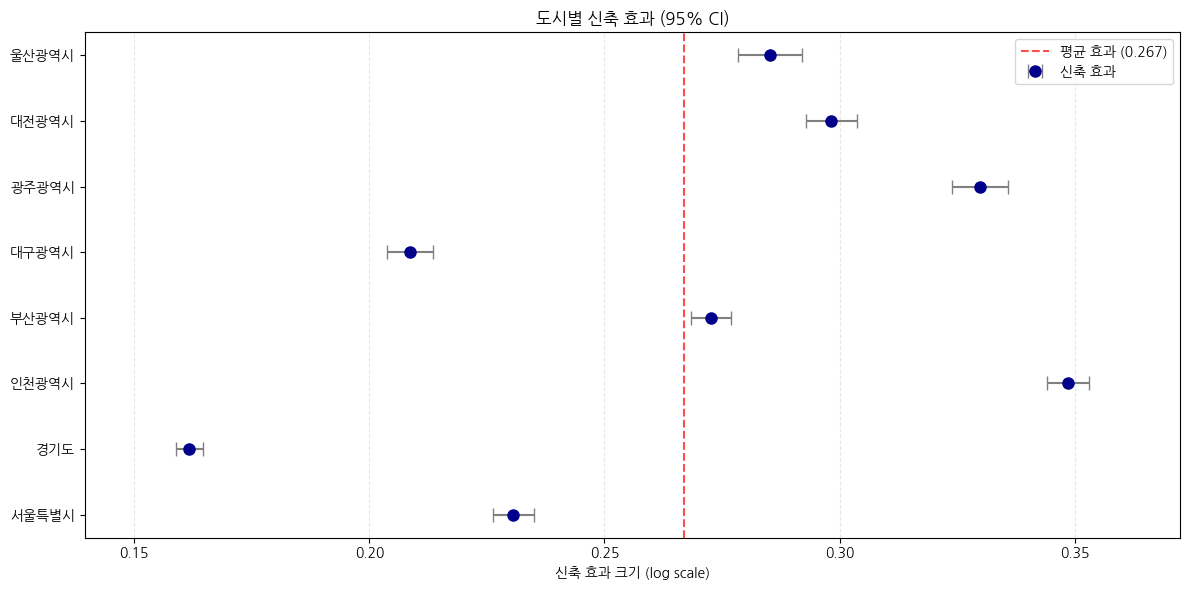

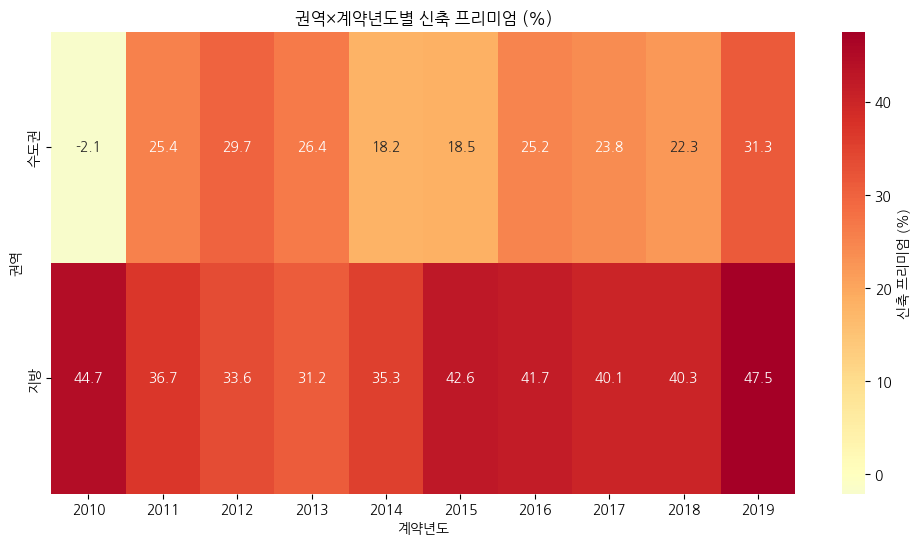

In [10]:
print("\n=== H3, H4 가설 검증 결과 분석 ===", flush=True)

# 1. 시각화 함수들
def plot_forest():
    """도시별 신축 효과 Forest Plot"""
    plt.figure(figsize=(12, 6))

    # 도시별 모델 결과 추출
    cities = ['서울특별시', '경기도', '인천광역시', '부산광역시', '대구광역시', '광주광역시', '대전광역시', '울산광역시']
    effects = []

    for city in cities:
        city_data = sampled_df[sampled_df['도시'] == city]
        if len(city_data) > 0:  # 데이터가 있는 경우만 처리
            # 도시별 신축 효과 계산
            old = np.average(
                city_data[~city_data['is_new_building']]['log_price_per_m2'],
                weights=city_data[~city_data['is_new_building']]['weights']
            )
            new = np.average(
                city_data[city_data['is_new_building']]['log_price_per_m2'],
                weights=city_data[city_data['is_new_building']]['weights']
            )
            effect = new - old

            # 표준오차 계산 (가중치 적용)
            n_eff = len(city_data)  # 유효 표본 크기
            se = np.sqrt(city_data['log_price_per_m2'].var() / n_eff)

            effects.append({
                'city': city,
                'effect': effect,
                'ci_lower': effect - 1.96 * se,
                'ci_upper': effect + 1.96 * se
            })

    if effects:  # 결과가 있는 경우만 처리
        effects_df = pd.DataFrame(effects)

        # 평균 효과 계산
        mean_effect = effects_df['effect'].mean()

        # y축 위치 조정 (데이터가 있는 도시만)
        y_positions = range(len(effects_df))

        # 효과 크기의 최소값 찾기
        min_effect = effects_df['ci_lower'].min()
        max_effect = effects_df['ci_upper'].max()

        # Forest Plot
        plt.errorbar(effects_df['effect'], y_positions,
                    xerr=[effects_df['effect'] - effects_df['ci_lower'],
                          effects_df['ci_upper'] - effects_df['effect']],
                    fmt='o', capsize=5, color='darkblue', markersize=8,
                    ecolor='gray', label='신축 효과')

        # 평균선 추가
        plt.axvline(x=mean_effect, color='red', linestyle='--', alpha=0.7,
                   label=f'평균 효과 ({mean_effect:.3f})')

        # 축 설정
        plt.yticks(y_positions, effects_df['city'])
        plt.xlabel('신축 효과 크기 (log scale)')
        plt.title('도시별 신축 효과 (95% CI)')

        # 그리드 추가
        plt.grid(True, axis='x', linestyle='--', alpha=0.3)

        # x축 범위 설정 (여백 추가)
        margin = (max_effect - min_effect) * 0.1
        plt.xlim(min_effect - margin, max_effect + margin)

        # 범례 추가
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()
    else:
        print("도시별 효과를 계산할 수 있는 데이터가 없습니다.", flush=True)

def plot_heatmap():
    """권역×계약년도별 신축 프리미엄 히트맵"""
    plt.figure(figsize=(12, 6))

    # 연도별, 권역별 신축/구축 평균 가격 계산
    premium_data = []

    for (region, year), group in sampled_df.groupby(['권역', '계약년도']):
        # 신축/구축 평균 가격 계산 (가중치 적용)
        new_price = np.average(
            group[group['is_new_building']]['log_price_per_m2'],
            weights=group[group['is_new_building']]['weights']
        )
        old_price = np.average(
            group[~group['is_new_building']]['log_price_per_m2'],
            weights=group[~group['is_new_building']]['weights']
        )

        # 프리미엄 계산 (%)
        premium_percent = (np.exp(new_price - old_price) - 1) * 100

        premium_data.append({
            '권역': region,
            '계약년도': year,
            'premium': premium_percent
        })

    premium_df = pd.DataFrame(premium_data)

    # 데이터 피벗
    premium_pivot = premium_df.pivot(index='권역', columns='계약년도', values='premium')

    # 히트맵
    sns.heatmap(premium_pivot, cmap='RdYlBu_r', center=0,
                annot=True, fmt='.1f',
                cbar_kws={'label': '신축 프리미엄 (%)'})
    plt.title('권역×계약년도별 신축 프리미엄 (%)')
    plt.show()

def calculate_liquidity_adjusted_index():
    """거래량 가중치를 활용한 유동성 조정 투자 매력도 지수 산출"""
    results = {}

    for region in ['수도권', '지방']:
        region_data = sampled_df[sampled_df['권역'] == region]

        # 신축 프리미엄
        premium = np.exp(cohens_d_results[region]) - 1

        # 거래량 가중치
        volume_weight = region_data['weights'].sum() / sampled_df['weights'].sum()

        # 투자 매력도 지수 (프리미엄 × 거래량 가중치)
        index = premium * volume_weight

        results[region] = {
            'premium': premium,
            'volume_weight': volume_weight,
            'index': index
        }

    return results

# 2. 결과 분석 및 출력
print("\n## H3, H4 가설 검증 결과 요약", flush=True)

# 회귀모델 계수 추출
if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model = regression_models['interaction_model']
    interaction_coef = model.params.get('C(is_new_building)[T.True]', np.nan)
    interaction_pvalue = model.pvalues.get('C(is_new_building)[T.True]', np.nan)
    region_interaction_coef = model.params.get('C(is_new_building)[T.True]:C(권역)[T.지방]', np.nan)
    region_interaction_pvalue = model.pvalues.get('C(is_new_building)[T.True]:C(권역)[T.지방]', np.nan)
else:
    print("Warning: 상호작용 모델 결과가 없습니다.", flush=True)
    interaction_coef = interaction_pvalue = region_interaction_coef = region_interaction_pvalue = np.nan

# H3 검증
h3_effects = {}
for region in ['수도권', '지방']:
    data = plot_df_interaction[plot_df_interaction['권역'] == region]
    old = data[data['is_new_building'] == False]['weighted_mean'].iloc[0]
    new = data[data['is_new_building'] == True]['weighted_mean'].iloc[0]
    premium_percent = (np.exp(new - old) - 1) * 100
    h3_effects[region] = premium_percent

h3_support = all(abs(premium) >= 5 for premium in h3_effects.values())

print("\n✅ H3 가설 검증 결과:", flush=True)
print("H3. 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가진다.", flush=True)
print(f"결론: {'✔️ 채택' if h3_support else '❌ 기각'}", flush=True)
print("근거:", flush=True)
for region, premium in h3_effects.items():
    print(f"- {region} 신축 프리미엄: {premium:.2f}%", flush=True)
if not np.isnan(interaction_coef):
    print(f"- 기본 신축 효과 계수: {interaction_coef:.4f} (p-value: {interaction_pvalue:.4f})", flush=True)

# H4 검증
local_premium = h3_effects['지방']
metro_premium = h3_effects['수도권']
premium_ratio = local_premium / metro_premium

h4_support = (premium_ratio > 1.1) and (not np.isnan(region_interaction_pvalue)) and (region_interaction_pvalue < 0.05)

print("\n✅ H4 가설 검증 결과:", flush=True)
print("H4. 수도권보다는 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다.", flush=True)
print(f"결론: {'✔️ 채택' if h4_support else '❌ 기각'}", flush=True)
print("근거:", flush=True)
print(f"- 지방 신축 프리미엄이 수도권 대비 {premium_ratio:.2f}배", flush=True)
print(f"- 지방 신축 아파트가 평당 {local_premium - metro_premium:.2f}% 높은 프리미엄", flush=True)
if not np.isnan(region_interaction_coef):
    print(f"- 지역 상호작용 계수: {region_interaction_coef:.4f} (p-value: {region_interaction_pvalue:.4f})", flush=True)

# 3. 투자 매력도 분석
print("\n### 투자 매력도 평가 (H3, H4 가설 기반)", flush=True)

if h3_support and h4_support:
    print("\n💰 지방 신축 아파트 투자 매력:", flush=True)
    print("H3, H4 가설이 모두 지지되므로, 특히 지방 광역시의 신축 아파트는 수도권 대비 높은 신축 프리미엄과 더 큰 가격 영향력을 가질 수 있어 투자 매력도가 높다고 평가할 수 있습니다. 이는 지방 시장의 특정 요인이 신축 가치를 더욱 부각시키는 것으로 해석됩니다.", flush=True)
    print(f"- 지방 신축 프리미엄은 약 {h3_effects['지방']:.2f}%, 수도권은 약 {h3_effects['수도권']:.2f}%로 지방이 더 높습니다.", flush=True)

elif h3_support:
    print("\n💼 지역별 맞춤형 신축 투자:", flush=True)
    print("H3 가설은 지지되나 H4가 기각될 경우, 신축 여부가 지역별로 다른 효과를 가지지만, 반드시 지방이 수도권보다 더 큰 영향을 미친다고 보기는 어렵습니다. 따라서 각 지역의 신축 프리미엄 수준을 면밀히 검토한 맞춤형 투자 전략이 필요합니다.", flush=True)

elif not h3_support and not h4_support:
    print("\n🚫 투자 매력도 재고 필요:", flush=True)
    print("H3, H4 가설이 모두 기각될 경우, 신축 여부만으로는 지역별 차별적인 투자 매력도를 주장하기 어렵습니다. 다른 요인들을 추가 분석하여 투자 매력도를 재평가해야 합니다.", flush=True)

else:
    print("\n📊 추가 분석 필요:", flush=True)
    print("가설 검증 결과가 불확실하므로, 신축 여부에 대한 투자 매력도를 명확히 평가하기 위해서는 추가적인 분석이 필요합니다.", flush=True)

# 유동성 조정 투자 매력도 지수 계산
print("\n💼 유동성 조정 투자 매력도 지수:", flush=True)

# 지역별 유동성 조정 투자 매력도 지수 계산
liquidity_adjusted_index = {}
for region in ['수도권', '지방']:
    region_data = sampled_df[sampled_df['권역'] == region]

    # 신축 프리미엄 (%)
    premium = h3_effects[region]  # 이미 계산된 프리미엄 사용

    # 거래량 가중치
    volume_weight = region_data['weights'].sum() / sampled_df['weights'].sum()

    # 투자 매력도 지수 (프리미엄 × 거래량 가중치)
    index = premium * volume_weight

    liquidity_adjusted_index[region] = {
        'premium': premium,
        'volume_weight': volume_weight,
        'index': index
    }

# 결과 출력
for region, values in liquidity_adjusted_index.items():
    print(f"\n{region}:", flush=True)
    print(f"- 신축 프리미엄: {values['premium']:.2f}%", flush=True)
    print(f"- 거래량 가중치: {values['volume_weight']:.2f}", flush=True)
    print(f"- 투자 매력도 지수: {values['index']:.2f}", flush=True)

# 4. 시각화
print("\n## 시각화", flush=True)
plot_forest()
plot_heatmap()